# Idea for this notebook
The aim of this notebook is to investigate if a CfC network can learn the dynamics of a flying drone. For this we have the `starry night` dataset which contains a time series of odometry measurements and landmark measurements.

The input size for the network is the sum of the size of the odomentry measurements and the landmark measurements. The odometry measurments are 6 dimensional (3 translational axes and 3 rotational axes). The landmark measurements are 80 dimensional (20 landmarks with x_l, y_l and x_r, y_r position). And for the timestep length we have one input. Which gives us an input of size 87 for each timestep.

The output is simply the state of the drone i.e. vector of size 6 (x,y,z position and rotation along x,y,z axis).

The next step is to formulate a loss function. We can use a simple MSE between the predicted and the ground truth position.

What I am not so sure about is how to batch the training data. One approach would be to have just a batch with one sequence e.g. the first 200 timesteps. Another approach would be to have batches with multiple fairly short sequences e.g. 200 sequences with just one timestep each.

In [39]:
import numpy as np
import torch
import torch.utils.data as tdata
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC
from scipy.io import loadmat
import pytorch_lightning as pl

In [153]:
data = loadmat('../data/dataset3.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'theta_vk_i', 'r_i_vk_i', 't', 'w_vk_vk_i', 'v_vk_vk_i', 'rho_i_pj_i', 'y_k_j', 'C_c_v', 'rho_v_c_v', 'w_var', 'v_var', 'y_var', 'fu', 'fv', 'cu', 'cv', 'b'])

In [154]:
data['theta_vk_i'].shape, data['r_i_vk_i'].shape, data['t'].shape, data['rho_i_pj_i'].shape, data['y_k_j'].shape

((3, 1900), (3, 1900), (1, 1900), (3, 20), (4, 1900, 20))

In [233]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y, timespans = batch
        y_hat, _ = self.model.forward(x, timespans=timespans)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y, timespans = batch
        y_hat, _ = self.model.forward(x, timespans=timespans)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [227]:
np.diff(data['theta_vk_i'][1,:]).max()

0.8844487660456931

In [250]:
# out_features = 1
# in_features = 2

# wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

# ltc_model = LTC(in_features, wiring, batch_first=True)
# wiring = AutoNCP(20, out_features)
cfc_model = CfC(input_size=86, units=20, proj_size=6, batch_first=True, return_sequences=True)

learn = SequenceLearner(cfc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [251]:
y_k_j = data['y_k_j'].transpose((0,2,1)).reshape(80, 1900)

In [252]:
data['t'].shape, data['w_vk_vk_i'].shape, data['v_vk_vk_i'].shape, y_k_j.shape

((1, 1900), (3, 1900), (3, 1900), (80, 1900))

In [253]:
T = np.diff(data['t'], axis=1)
T.shape

(1, 1899)

In [254]:
data_y = np.expand_dims(np.vstack([data['theta_vk_i'][:,1:], data['r_i_vk_i'][:,1:]]).T, axis=0).astype(np.float32)
data_x = np.expand_dims(np.vstack([data['w_vk_vk_i'][:,:-1], data['v_vk_vk_i'][:,:-1], y_k_j[:,:-1]]).T, axis=0).astype(np.float32)
data_y.shape, data_x.shape

((1, 1899, 6), (1, 1899, 86))

In [255]:
num_train_steps = 400  # train network on first 200 steps and simulate the rest of the trajectory
train_data_x, test_data_x = data_x[:, :num_train_steps,:], data_x[:, num_train_steps:,:]
train_data_y, test_data_y = data_y[:, :num_train_steps,:], data_y[:, num_train_steps:,:]
train_timespans, test_timespans = T[:,:num_train_steps], T[:,num_train_steps:]

# create torch dataloaders
train_data_x, test_data_x = torch.Tensor(train_data_x), torch.Tensor(test_data_x)
train_data_y, test_data_y = torch.Tensor(train_data_y), torch.Tensor(test_data_y)
train_timespans, test_timespans = torch.Tensor(train_timespans), torch.Tensor(test_timespans)
train_dataloader = tdata.DataLoader(
    tdata.TensorDataset(train_data_x, train_data_y, train_timespans), batch_size=1, shuffle=False, num_workers=4
)
test_dataloader = tdata.DataLoader(
    tdata.TensorDataset(test_data_x, test_data_y, test_timespans), batch_size=1, shuffle=False, num_workers=4
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d2e91e91c00>,
 <torch.utils.data.dataloader.DataLoader at 0x7d2e91e92170>)

In [ ]:
trainer.fit(learn, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CfC  | 24.1 K
-------------------------------
24.1 K    Trainable params
0         Non-trainable params
24.1 K    Total params
0.097     Total estimated model params size (MB)


Training: |                                                                                                   …

In [245]:
# evaluation on the test data and generation of trajectory a
x,y, t = next(iter(test_dataloader))
a,b = learn.model.forward(x.to('cpu'), timespans=t)
a.shape, b.shape

(torch.Size([1, 1499, 6]), torch.Size([1, 10]))

In [92]:
import matplotlib.pyplot as plt

def plot_3D_trajectory(data, label='trajectory', ax=None):
    # 3D plot of vehicle position ground truth
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    ax.plot(data[0,:], data[1,:],data[2,:], label=label)
    ax.legend()
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    return ax

<Axes3D: xlabel='X Axis', ylabel='Y Axis', zlabel='Z Axis'>

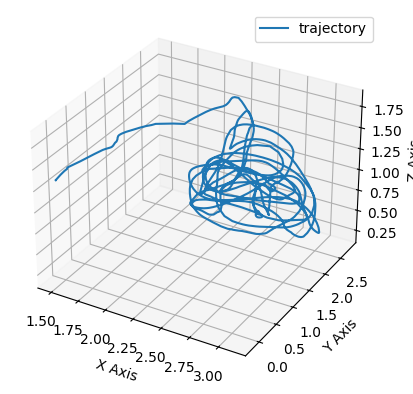

In [246]:
plot_3D_trajectory(test_data_y.numpy()[0, :,3:].T)

<Axes3D: xlabel='X Axis', ylabel='Y Axis', zlabel='Z Axis'>

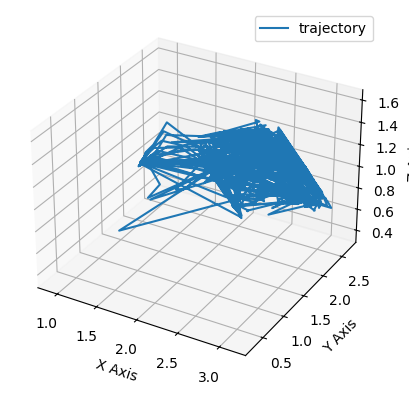

In [247]:
plot_3D_trajectory(a.detach().numpy()[0, :,3:].T)

In [248]:
a

tensor([[[ 1.2775, -1.4508,  0.8424,  2.2356,  2.1950,  1.1247],
         [ 1.2549, -1.2609,  1.1077,  2.2228,  2.4459,  1.1056],
         [ 1.2959, -1.1935,  1.1870,  2.1471,  2.4193,  1.0960],
         ...,
         [ 1.1233, -1.4631,  0.8500,  2.5711,  2.4956,  1.0768],
         [ 1.1213, -1.4607,  0.8553,  2.5660,  2.5061,  1.0806],
         [ 1.1196, -1.4587,  0.8599,  2.5613,  2.5154,  1.0840]]],
       grad_fn=<StackBackward0>)

In [249]:
y

tensor([[[ 1.9934, -0.2898,  2.0927,  2.0406,  2.2192,  0.8171],
         [ 1.9707, -0.2870,  2.0656,  2.0342,  2.2419,  0.8184],
         [ 1.9658, -0.2893,  2.0560,  2.0322,  2.2529,  0.8186],
         ...,
         [ 2.1836, -2.2368,  0.0218,  1.5034, -0.1673,  1.3565],
         [ 2.1839, -2.2360,  0.0210,  1.5034, -0.1674,  1.3566],
         [ 2.1836, -2.2367,  0.0229,  1.5034, -0.1673,  1.3565]]])

In [163]:
learn.test_step((x.to('cuda'), y.to('cuda')), 0)

ValueError: not enough values to unpack (expected 3, got 2)